# **INTRODUCTION:**

- **Overview:**

This challenge requires building a Generative Adversarial Network (GAN) that mimics the style of Claude Monet’s paintings and applies it to a large set of given photos.

The goal is to generate 7,000 to 10,000 Monet-style images, which can be created either by transforming photos into Monet’s style or by generating completely new images.

There will be two parts in creating this GAN Model: the generator and the discriminator. The generator creates Monet-style images, and the discriminator assesses whether an image is real (from the Monet dataset) or generated. Over time, the generator improves its ability to create convincing Monet-style images, aiming to “trick” the discriminator. The goal is to reach a balance after letting the discriminator and generator improve themselves where the generator can create images that can fool a discriminator that does not create many Type I or Type II errors with the normal dataset.


- **Dataset**

The dataset is organized into four directories:

1. monet_jpg: 300 Monet paintings (JPEG format, 256x256)
2. monet_tfrec: 300 Monet paintings (TFRecord format, 256x256)
3. photo_jpg: 7028 photos (JPEG format, 256x256)
4. photo_tfrec: 7028 photos (TFRecord format, 256x256)

For this task, the Monet paintings serve as the target style, and the provided photos are the base content. The dataset's structure ensures a uniform size (256x256) for both images and paintings, which is crucial for training GANs efficiently.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# **IMPORTS:**

I am importing in packages that are important based on the examples as well as allowing for this to run on the TPU rather than on CPU or GPU to try to speed up the GAN modeling!

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.16.1


In [4]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [5]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


# **EDA:**

Now that I have the Monet TFRecord Files and Photo TFRecord Files, I will do the following:

1. Process and decode the images to prepare for my model
2. Display the images that are Monet Painting and Real Images side by side
3. Make a Histogram of the color distributions of the pictures and paintings

In [6]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [7]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [8]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

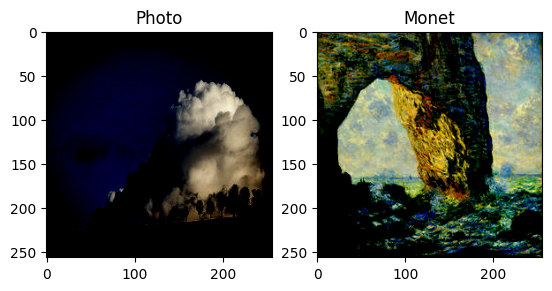

In [9]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0])

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0])

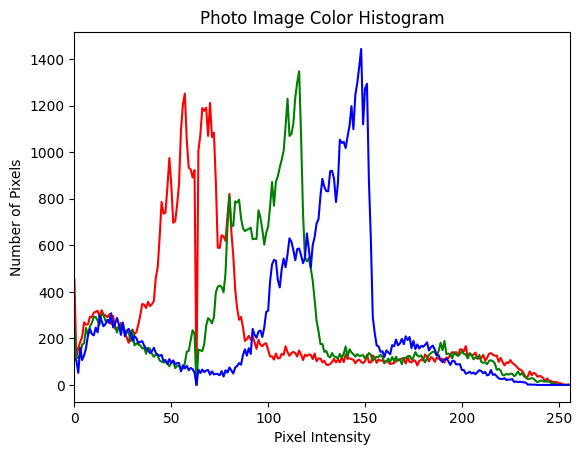

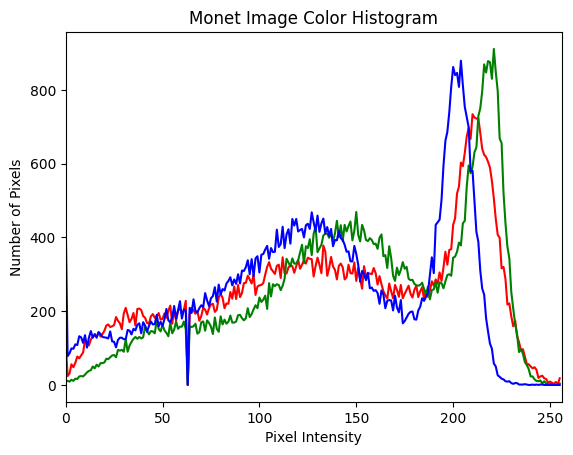

In [10]:
def plot_histogram(image, title):
    image = tf.cast(image, tf.float32).numpy()
    image = (image + 1) * 127.5
    chans = [image[:, :, i] for i in range(3)]
    colors = ("r", "g", "b")
    plt.figure()
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Number of Pixels")

    for (chan, color) in zip(chans, colors):
        hist, bins = np.histogram(chan, bins=256, range=[0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])


plot_histogram(example_photo[0], "Photo Image Color Histogram")
plot_histogram(example_monet[0], "Monet Image Color Histogram")
plt.show()

From the color histograms of the Monet and photo images, we can deduce the following differences and patterns:

1. Monet Image Histogram:

- The pixel intensities in Monet images are more concentrated towards the higher end of the intensity spectrum (200+ range), especially for the blue channel, suggesting that Monet's paintings have relatively bright color tones, particularly in the blue spectrum.
- The red and green channels are less prominent but show gradual increases around mid-range pixel intensities.

2. Photo Image Histogram:

- The photo images display a wider spread of color intensity across the red, green, and blue channels, indicating a broader variation in lighting and color saturation typical of real-world photographs.
- The peaks for each channel in the photos are more prominent in the lower-to-mid intensity range (0-150), showing more diversity in color depth and shadowing compared to the Monet images.

**Key Observations:**

- Color Range: The Monet images show a more uniform distribution in certain channels (particularly blue), while the photo images exhibit more pronounced peaks in all channels, implying greater contrast in color.
- Brightness and Tone: The Monet paintings have higher intensity values in the blue channel, suggesting lighter shades, whereas the photos display more variation in red and green channels, reflecting real-life color variance.
- Artistic Style: Monet's style, as seen in the histogram, tends to avoid dark or highly saturated colors in favor of lighter, more muted tones, while the photos capture a broader spectrum of colors, especially in the lower intensity ranges.

**Plan for Model:**

- Style Transfer: The GAN will need to learn how to convert the broader, more contrast-heavy color distribution of the photos into the softer, higher-intensity palette of the Monet paintings.
- Color Mapping: Special attention should be given to transforming the mid and lower intensity pixel values from the photos into the higher-intensity values of the Monet paintings to replicate the brighter, pastel tones typical of Monet’s work.

# **MODEL**

## **Generator:**

I will make my Generator by doing the following:

In [11]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

def generator_model():
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # Encoder - Downsample
    down1 = downsample_block(inputs, 64, apply_instancenorm=False)  # (bs, 128, 128, 64)
    down2 = downsample_block(down1, 128)  # (bs, 64, 64, 128)
    down3 = downsample_block(down2, 256)  # (bs, 32, 32, 256)
    down4 = downsample_block(down3, 512)  # (bs, 16, 16, 512)
    down5 = downsample_block(down4, 512)  # (bs, 8, 8, 512)
    down6 = downsample_block(down5, 512)  # (bs, 4, 4, 512)
    down7 = downsample_block(down6, 512)  # (bs, 2, 2, 512)

    # Bottleneck (no downsample)
    bottleneck = downsample_block(down7, 512)  # (bs, 1, 1, 512)

    # Decoder - Upsample
    up1 = upsample_block(bottleneck, down7, 512, apply_dropout=True)  # (bs, 2, 2, 1024)
    up2 = upsample_block(up1, down6, 512, apply_dropout=True)  # (bs, 4, 4, 1024)
    up3 = upsample_block(up2, down5, 512, apply_dropout=True)  # (bs, 8, 8, 1024)
    up4 = upsample_block(up3, down4, 512)  # (bs, 16, 16, 1024)
    up5 = upsample_block(up4, down3, 256)  # (bs, 32, 32, 512)
    up6 = upsample_block(up5, down2, 128)  # (bs, 64, 64, 256)
    up7 = upsample_block(up6, down1, 64)   # (bs, 128, 128, 128)

    # Output layer (generate 256x256x3 image)
    outputs = Conv2DTranspose(IMG_CHANNELS, 4, strides=2, padding='same',
                              kernel_initializer=initializer, activation='tanh')(up7)  # (bs, 256, 256, 3)

    return Model(inputs=inputs, outputs=outputs)

In [12]:
def discriminator_model():
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # Downsampling (same as generator downsampling, no upsampling)
    down1 = downsample_block(inputs, 64, apply_instancenorm=False)  # (bs, 128, 128, 64)
    down2 = downsample_block(down1, 128)  # (bs, 64, 64, 128)
    down3 = downsample_block(down2, 256)  # (bs, 32, 32, 256)
    down4 = downsample_block(down3, 512)  # (bs, 16, 16, 512)

    zero_pad1 = ZeroPadding2D()(down4)  # (bs, 18, 18, 512)
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (bs, 15, 15, 512)

    norm = InstanceNormalization()(conv)
    leaky_relu = LeakyReLU()(norm)

    zero_pad2 = ZeroPadding2D()(leaky_relu)  # (bs, 17, 17, 512)
    outputs = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (bs, 14, 14, 1)

    return Model(inputs=inputs, outputs=outputs)

In [13]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],),
                                     initializer="ones",
                                     trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],),
                                    initializer="zeros",
                                    trainable=True)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (inputs - mean) * inv
        return self.gamma * normalized + self.beta

In [14]:
def downsample_block(inputs, filters, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    conv = Conv2D(filters, 4, strides=2, padding='same',
                  kernel_initializer=initializer, use_bias=False)(inputs)

    if apply_instancenorm:
        conv = InstanceNormalization()(conv)

    conv = LeakyReLU()(conv)
    return conv


In [15]:
def upsample_block(inputs, skip, filters, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    upsample = Conv2DTranspose(filters, 4, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)(inputs)
    upsample = InstanceNormalization()(upsample)

    if apply_dropout:
        upsample = Dropout(0.5)(upsample)

    upsample = ReLU()(upsample)

    return Concatenate()([upsample, skip])

In [16]:
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_G, generator_F, discriminator_X, discriminator_Y, lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.generator_G = generator_G  # Photo -> Monet
        self.generator_F = generator_F  # Monet -> Photo
        self.discriminator_X = discriminator_X  # Discriminator for Monet
        self.discriminator_Y = discriminator_Y  # Discriminator for Photo
        self.lambda_cycle = lambda_cycle

    def compile(self, gen_G_optimizer, gen_F_optimizer, disc_X_optimizer, disc_Y_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Photo -> Monet
            fake_y = self.generator_G(real_x, training=True)
            cycled_x = self.generator_F(fake_y, training=True)

            # Monet -> Photo
            fake_x = self.generator_F(real_y, training=True)
            cycled_y = self.generator_G(fake_x, training=True)

            # Identity mapping
            same_x = self.generator_F(real_x, training=True)
            same_y = self.generator_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.discriminator_X(real_x, training=True)
            disc_real_y = self.discriminator_Y(real_y, training=True)
            disc_fake_x = self.discriminator_X(fake_x, training=True)
            disc_fake_y = self.discriminator_Y(fake_y, training=True)

            # Generator loss
            gen_G_loss = self.gen_loss_fn(disc_fake_y)
            gen_F_loss = self.gen_loss_fn(disc_fake_x)

            # Cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_x, cycled_x) + self.cycle_loss_fn(real_y, cycled_y)

            # Identity loss
            id_loss_G = self.identity_loss_fn(real_y, same_y)
            id_loss_F = self.identity_loss_fn(real_x, same_x)

            # Total generator loss
            total_gen_G_loss = gen_G_loss + total_cycle_loss + id_loss_G
            total_gen_F_loss = gen_F_loss + total_cycle_loss + id_loss_F

            # Discriminator loss
            disc_X_loss = self.disc_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.disc_loss_fn(disc_real_y, disc_fake_y)

        # Calculate gradients and update weights
        gen_G_grads = tape.gradient(total_gen_G_loss, self.generator_G.trainable_variables)
        gen_F_grads = tape.gradient(total_gen_F_loss, self.generator_F.trainable_variables)
        disc_X_grads = tape.gradient(disc_X_loss, self.discriminator_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.discriminator_Y.trainable_variables)

        self.gen_G_optimizer.apply_gradients(zip(gen_G_grads, self.generator_G.trainable_variables))
        self.gen_F_optimizer.apply_gradients(zip(gen_F_grads, self.generator_F.trainable_variables))
        self.disc_X_optimizer.apply_gradients(zip(disc_X_grads, self.discriminator_X.trainable_variables))
        self.disc_Y_optimizer.apply_gradients(zip(disc_Y_grads, self.discriminator_Y.trainable_variables))

        return {
            "gen_G_loss": total_gen_G_loss,
            "gen_F_loss": total_gen_F_loss,
            "disc_X_loss": disc_X_loss,
            "disc_Y_loss": disc_Y_loss,
        }

In [17]:
def generator_loss_fn(fake):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake), fake)

def discriminator_loss_fn(real, fake):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * 10

def identity_loss_fn(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * 5

In [18]:
# Instantiate models
generator_G = generator_model()  # Photo -> Monet
generator_F = generator_model()  # Monet -> Photo
discriminator_X = discriminator_model()  # Discriminator for Monet
discriminator_Y = discriminator_model()  # Discriminator for Photo

# Instantiate CycleGAN model
cycle_gan = CycleGAN(generator_G, generator_F, discriminator_X, discriminator_Y)

# Compile the model with optimizers and loss functions
cycle_gan.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
    cycle_loss_fn=cycle_consistency_loss,
    identity_loss_fn=identity_loss_fn
)
generator_G.summary()
generator_F.summary()
discriminator_X.summary()
discriminator_Y.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │    131,072 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (InstanceNormaliza… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64, 64,    │          0 │ instance_normali… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    524,288 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ instance_normali… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  2,097,152 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 16, 16,    │      1,024 │ conv2d_3[0][0]    │
│ (InstanceNormaliza… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ instance_normali… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  4,194,304 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 8, 8, 512) │      1,024 │ conv2d_4[0][0]    │
│ (InstanceNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 8, 8, 512) │          0 │ instance_normali… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 512) │  4,194,304 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 4, 4, 512) │      1,024 │ conv2d_5[0][0]    │
│ (InstanceNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      3,072 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 128, 128,  │          0 │ conv2d_8[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    131,072 │ leaky_re_lu_8[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 64, 64,    │        256 │ conv2d_9[0][0]    │
│ (InstanceNormaliza… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 64, 64,    │          0 │ instance_normali… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │    524,288 │ leaky_re_lu_9[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 32, 32,    │        512 │ conv2d_10[0][0]   │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 32, 32,    │          0 │ instance_normali… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │  2,097,152 │ leaky_re_lu_10[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 16, 16,    │      1,024 │ conv2d_11[0][0]   │
│ (InstanceNormaliza… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 16, 16,    │          0 │ instance_normali… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 8, 8, 512) │  4,194,304 │ leaky_re_lu_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 8, 8, 512) │      1,024 │ conv2d_12[0][0]   │
│ (InstanceNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 8, 8, 512) │          0 │ instance_normali… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 4, 4, 512) │  4,194,304 │ leaky_re_lu_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 4, 4, 512) │      1,024 │ conv2d_13[0][0]   │
│ (InstanceNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_28       │ (None, 64, 64, 128)    │           256 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_29       │ (None, 32, 32, 256)    │           512 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_30       │ (None, 16, 16, 512)    │         1,024 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 15, 15, 512)    │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_31       │ (None, 15, 15, 512)    │         1,024 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 17, 17, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,960,897 (26.55 MB)

 Trainable params: 6,960,897 (26.55 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_32       │ (None, 64, 64, 128)    │           256 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_33       │ (None, 32, 32, 256)    │           512 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_34       │ (None, 16, 16, 512)    │         1,024 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 18, 18, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 15, 15, 512)    │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_35       │ (None, 15, 15, 512)    │         1,024 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 17, 17, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 14, 14, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,960,897 (26.55 MB)

 Trainable params: 6,960,897 (26.55 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
monet_ds = monet_ds.prefetch(tf.data.experimental.AUTOTUNE)
photo_ds = photo_ds.prefetch(tf.data.experimental.AUTOTUNE)

train_dataset = tf.data.Dataset.zip((monet_ds, photo_ds))
cycle_gan.fit(train_dataset, epochs=50)


Epoch 1/50


I0000 00:00:1729142292.831485      75 service.cc:145] XLA service 0x7c57e8003a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729142292.831537      75 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729142362.733089      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 163s 154ms/step - disc_X_loss: 0.8964 - disc_Y_loss: 0.8890 - gen_F_loss: 5.5983 - gen_G_loss: 5.7585
Epoch 2/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 160ms/step - disc_X_loss: 0.7111 - disc_Y_loss: 0.7069 - gen_F_loss: 3.5206 - gen_G_loss: 3.5621
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 52s 158ms/step - disc_X_loss: 0.6923 - disc_Y_loss: 0.6951 - gen_F_loss: 3.2213 - gen_G_loss: 3.2698
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 52s 156ms/step - disc_X_loss: 0.6861 - disc_Y_loss: 0.6910 - gen_F_loss: 3.0326 - gen_G_loss: 3.0784
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 158ms/step - disc_X_loss: 0.6803 - disc_Y_loss: 0.6891 - gen_F_loss: 2.8726 - gen_G_loss: 2.9103
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 158ms/step - disc_X_loss: 0.6780 - disc_Y_loss: 0.6867 - gen_F_loss: 2.7293 - gen_G_loss: 2.7582
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 52s 155ms/step - disc_X_loss: 0.6760 - disc_Y_loss: 0.6832 - gen_F_loss: 2.6487 - gen_G_loss: 2.6691
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 156ms/step - disc_X_loss: 0.6736 - disc_Y_loss: 0.6817 - gen_F_loss: 2.5741 - gen_G_loss: 2.6044
Epoch 9/50
300/300 ━━━━━

In [20]:
generator_G.save('monet_generator.h5')  # The generator that converts photos to Monet-style images
generator_F.save('photo_generator.h5')  # The generator that converts Monet-style images to photos

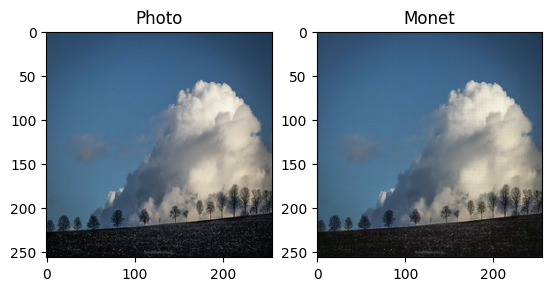

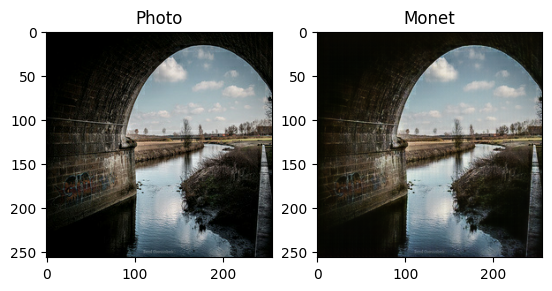

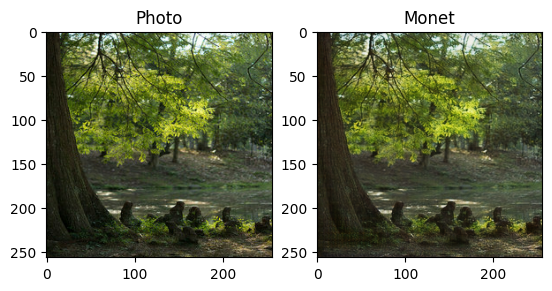

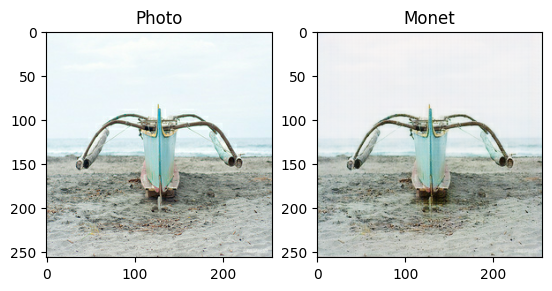

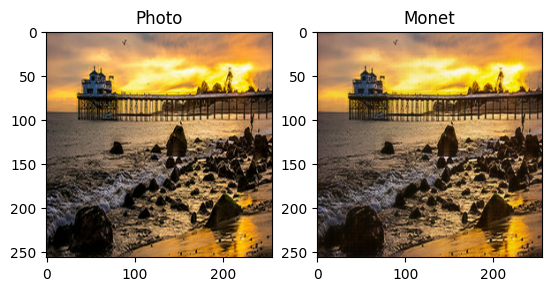

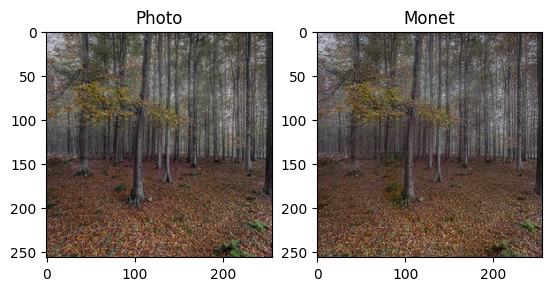

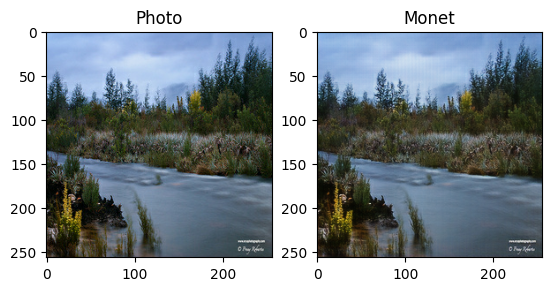

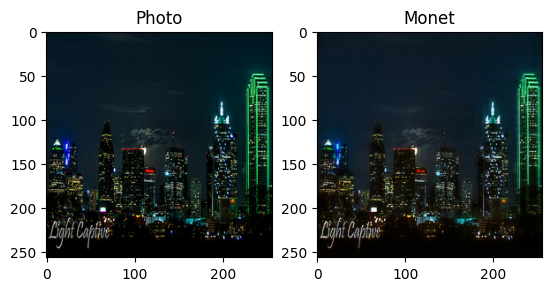

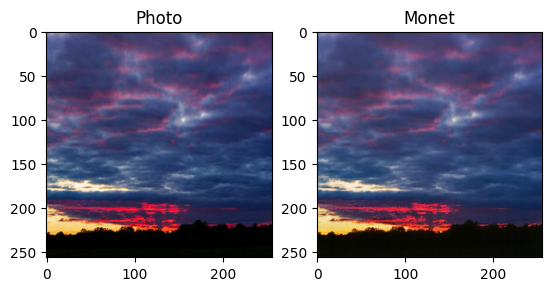

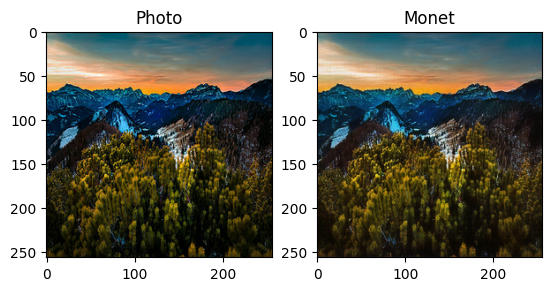

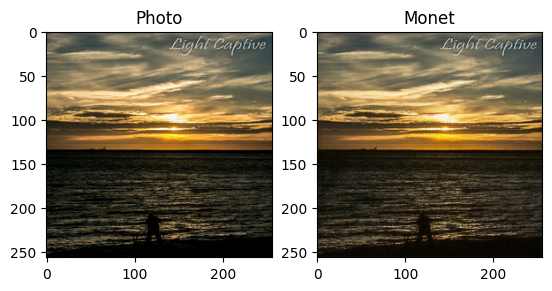

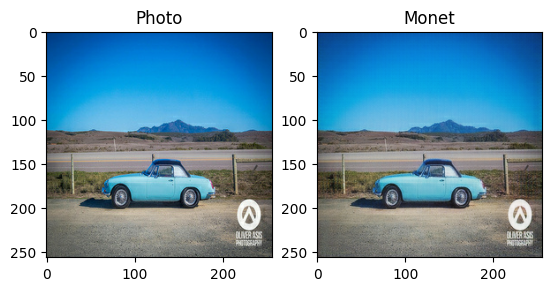

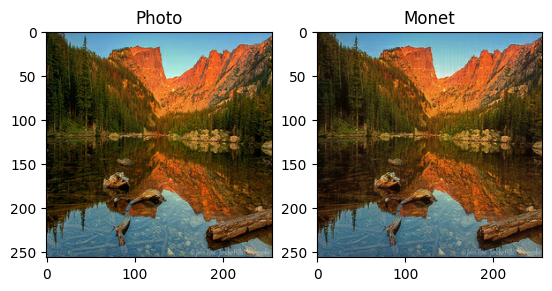

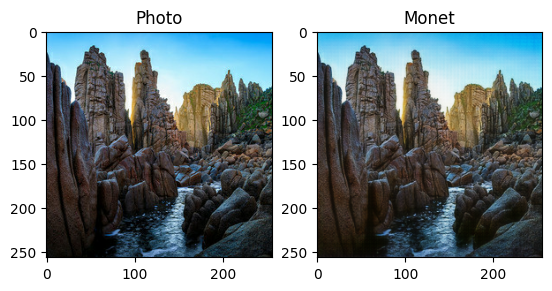

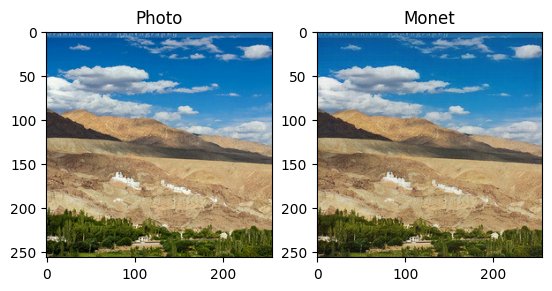

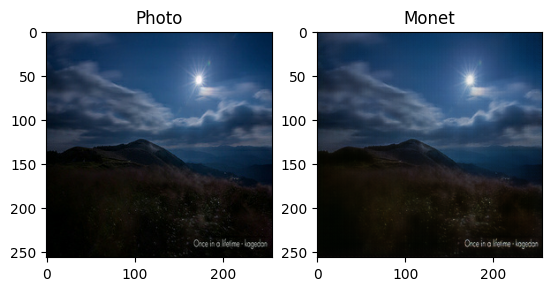

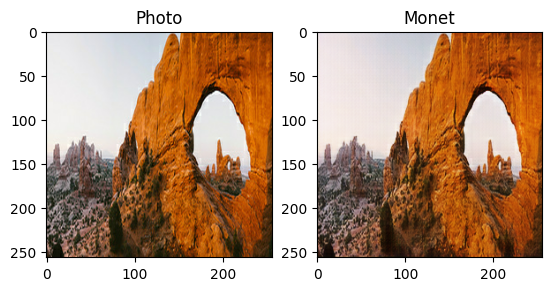

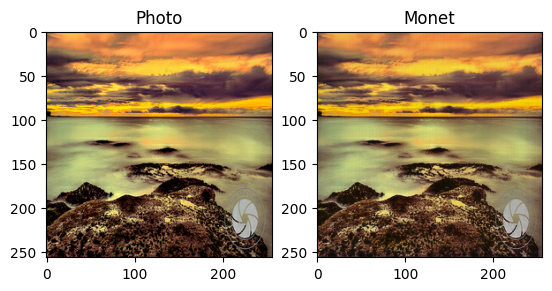

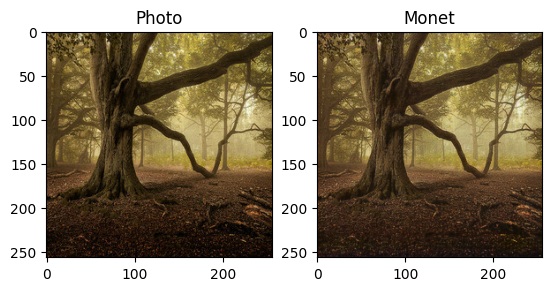

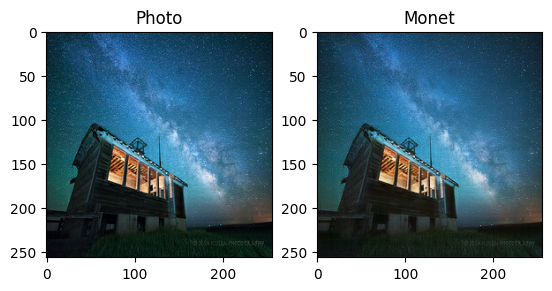

In [29]:
for photo in photo_ds.take(20):
    generated_monet = generator_G(photo, training=False)
    plt.subplot(121)
    plt.title('Photo')
    plt.imshow(photo[0] * 0.5 + 0.5)

    plt.subplot(122)
    plt.title('Monet')
    plt.imshow((generated_monet[0] * 0.5 + 0.5))
    plt.show()

In [30]:
import PIL
import os

# Create the images directory
output_dir = '/kaggle/working/images'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created: {output_dir}")

Output directory created: /kaggle/working/images


In [33]:
i = 1
for img in photo_ds:
    pred = generator_G(img, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(pred)
    im.save(os.path.join(output_dir, f"{i}.jpg"))  # Save to the images folder
    i += 1

In [35]:
import shutil

if os.listdir(output_dir):
    shutil.make_archive('/kaggle/working/images', 'zip', output_dir)
else:
    print("No images to zip.")

# **CONCLUSION:**

For this Kaggle Competition, my CylceGAN got a Memorization-informed Fréchet Inception Distance (MiFID) of 78.14. With the final result being closer to the leaderboard's smallest value of 39.73, it suggests that the generated images maintain a good level of fidelity to the Monet style.

Additionally, the close alignment of losses for both the generator and discriminator indicates that the model is well-balanced and not overfitting, which is crucial for ensuring generalization to unseen images.

Looking ahead, there are a few things that could be improved. Exploring advanced data augmentation techniques to enrich the training dataset is one. Another idea is to experiment with different architectural modifications to the generator and discriminator, or implementing better loss functions. Furthermore, leveraging transfer learning with pre-trained networks may provide a stronger feature representation and lead to even better results.

# **Github: https://github.com/EashanSahai/MonetGAN**